In [1]:
# Cargar Librerias Generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Carga de datos

In [2]:
# Cargar lista de insumos
dir = 'raw_data/'
file = 'files_list.csv'

file_df = pd.read_csv(dir + file, index_col='ind')

#Separar códigos bursátiles
pattern = r'\((.*?)\)'

file_df['stock'] = file_df['name'].str.extract(pattern)
file_df['name'] = file_df['name'].str.replace(pattern, '')

# Seleccionar el top de empresas a usar (siempre cargar negativos y 0)
top_n = 10

file_df = file_df[file_df.index < top_n + 1]
file_df

C:\Users\Carlos\AppData\Local\Temp\ipykernel_22320\287536555.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  file_df['name'] = file_df['name'].str.replace(pattern, '')


,name,stock
ind,,
-2,FEDFUNDS,FEDFUNDS
-1,UNRATE,UNRATE
0,NASDAQ 100,^NDX
1,Apple Inc.,AAPL
2,Microsoft Corporation,MSFT
3,"Amazon.com, Inc.",AMZN
4,NVIDIA Corporation,NVDA
5,"Meta Platforms, Inc.",META
6,Broadcom Inc.,AVGO


In [3]:
# Cargar archivos en dataframe y gardarlos en diccionario
stocks_dict = {}

for f in file_df['stock']:
    file = f + '.csv'
    df_name = f + '_DF'
    df = pd.read_csv(dir + file)
    stocks_dict[df_name] = df
    
stocks_dict.keys()

dict_keys(['FEDFUNDS_DF', 'UNRATE_DF', '^NDX_DF', 'AAPL_DF', 'MSFT_DF', 'AMZN_DF', 'NVDA_DF', 'META_DF', 'AVGO_DF', 'TSLA_DF', 'GOOG_DF', 'GOOGL_DF', 'ADBE_DF'])

# Preprocesado de datos

In [4]:
# Parsear formato de fechas para FEDFUNDS y UNRATE
macros = ['FEDFUNDS_DF', 'UNRATE_DF']
stocks = [key for key in stocks_dict.keys() if key not in macros]

for i in macros:
    stocks_dict[i].iloc[:,0] = pd.to_datetime(stocks_dict[i].iloc[:,0], format='%d/%m/%Y')
    stocks_dict[i].iloc[:,0] = stocks_dict[i].iloc[:,0].dt.strftime('%Y-%m-%d')
    
    # Cambiar nombre de columna a Date
    stocks_dict[i].rename(columns= {'DATE' : 'Date'}, inplace= True)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_22320\1753323311.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stocks_dict[i].iloc[:,0] = pd.to_datetime(stocks_dict[i].iloc[:,0], format='%d/%m/%Y')
C:\Users\Carlos\AppData\Local\Temp\ipykernel_22320\1753323311.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stocks_dict[i].iloc[:,0] = stocks_dict[i].iloc[:,0].dt.strftime('%Y-%m-%d')
C:\Users\Carlos\AppData\Local\Temp\ipykernel_22320\1753323311.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set 

In [5]:
# Visualización de los dataframe
stocks_dict['FEDFUNDS_DF']

,Date,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
829,2023-08-01,5.33
830,2023-09-01,5.33
831,2023-10-01,5.33
832,2023-11-01,5.33


In [6]:
# Seleccionar variables que nos interesan y eliminar las demas de los DF
variables = ['Date', 'FEDFUNDS', 'UNRATE', 'Open', 'Close', 'Volume']

for df in stocks_dict.keys():
    for col in stocks_dict[df].columns:
        if col not in variables:
            stocks_dict[df].drop(col, axis= 1, inplace= True)
            
stocks_dict['AAPL_DF'].columns

Index(['Date', 'Open', 'Close', 'Volume'], dtype='object')

In [7]:
# Definimos fechas inicio y fin, eliminaremos todo lo que no esté en este rango
start_date= '2012-06-01'           # Usamos esta fecha porque es cuando Meta (la más reciente, entro en cotización)
end_date= '2023-12-31'

for df in stocks_dict.keys():
    stocks_dict[df].drop(stocks_dict[df][stocks_dict[df]['Date'] < start_date].index, inplace=True)
    stocks_dict[df].drop(stocks_dict[df][stocks_dict[df]['Date'] > end_date].index, inplace=True)

stocks_dict['FEDFUNDS_DF']

,Date,FEDFUNDS
695,2012-06-01,0.16
696,2012-07-01,0.16
697,2012-08-01,0.13
698,2012-09-01,0.14
699,2012-10-01,0.16
...,...,...
829,2023-08-01,5.33
830,2023-09-01,5.33
831,2023-10-01,5.33
832,2023-11-01,5.33


In [8]:
# Visualizar información de cada DF y alertar por nulos y duplicados
for df in stocks_dict.keys():
    print('***** '+ df +' *****')
    stocks_dict[df].info()
    
    null_values = stocks_dict[df].isnull().any()
    if null_values.any():
        print("Advertencia: " + df + " contiene nulos!!")
        
    duplicated_rows = stocks_dict[df].duplicated()
    if duplicated_rows.any():
        print("Advertencia: " + df + " contiene duplicados!!") 
    
    print()
    print()

***** FEDFUNDS_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 695 to 833
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      139 non-null    object 
 1   FEDFUNDS  139 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


***** UNRATE_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 773 to 911
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    139 non-null    object 
 1   UNRATE  139 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


***** ^NDX_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 6726 to 9639
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2914 non-null   object 
 1   Open    2914 non-null   float64
 2   Close   2914 non-null   float64
 3   Volume  291

# Análisis Exploratorio

In [9]:
# Visualizar información de cada DF y alertar por nulos y duplicados
for df in stocks_dict.keys():
    print('***** '+ df +' *****')
    print(stocks_dict[df].describe())
    print()
    print()

***** FEDFUNDS_DF *****
         FEDFUNDS
count  139.000000
mean     1.119568
std      1.490514
min      0.050000
25%      0.090000
50%      0.360000
75%      1.695000
max      5.330000


***** UNRATE_DF *****
           UNRATE
count  139.000000
mean     5.260432
std      1.895480
min      3.400000
25%      3.800000
50%      4.800000
75%      6.200000
max     14.800000


***** ^NDX_DF *****
               Open         Close        Volume
count   2914.000000   2914.000000  2.914000e+03
mean    7727.255158   7729.470973  2.923642e+09
std     4202.526633   4203.448103  1.517643e+09
min     2458.969971   2458.830078  2.441200e+08
25%     4297.375000   4296.544800  1.817850e+09
50%     6636.185059   6643.979980  2.141175e+09
75%    11633.947266  11675.142822  4.250430e+09
max    16963.519531  16906.800781  1.162119e+10


***** AAPL_DF *****
              Open        Close        Volume
count  2914.000000  2914.000000  2.914000e+03
mean     69.767093    69.819398  1.776664e+08
std      56.02

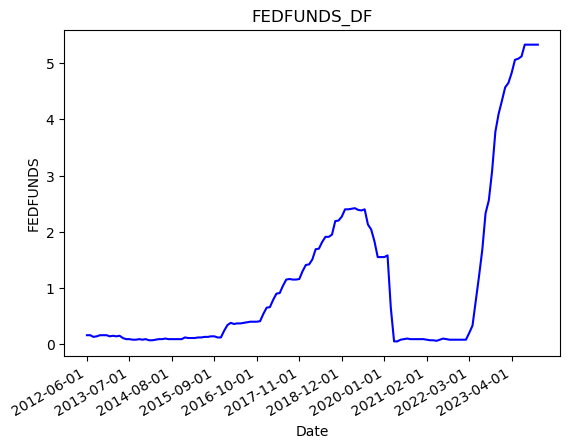

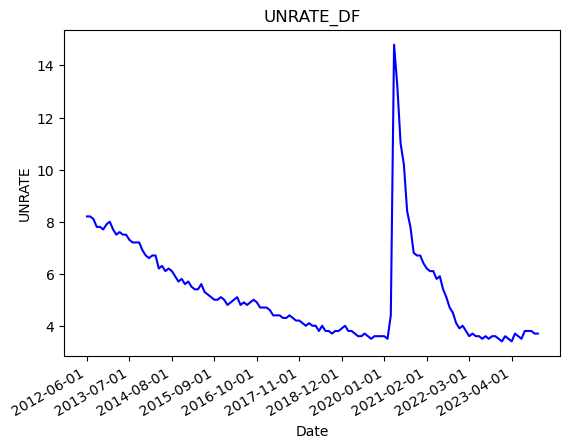

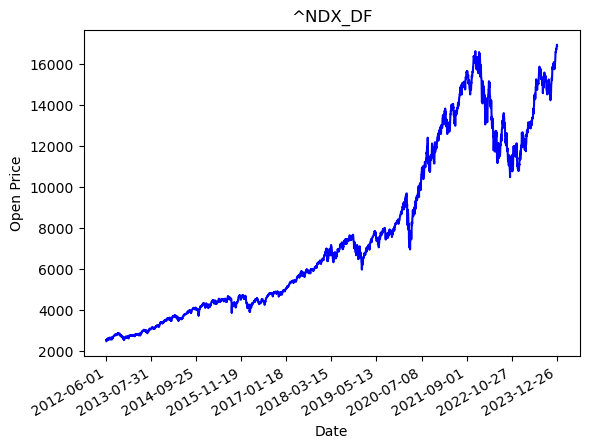

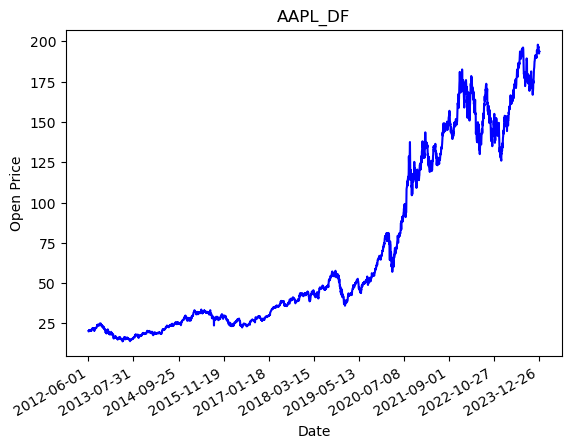

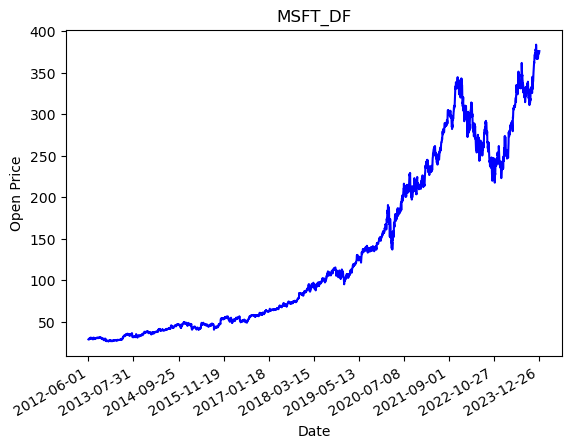

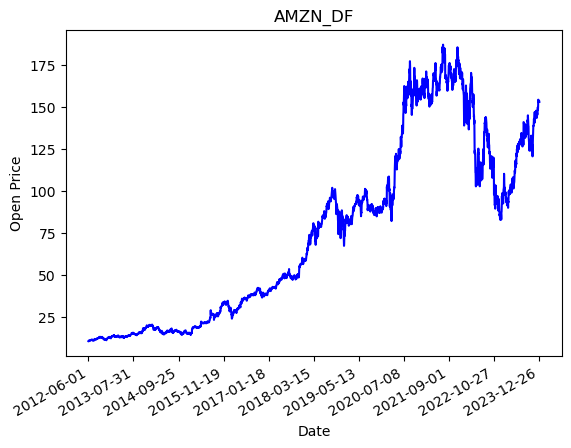

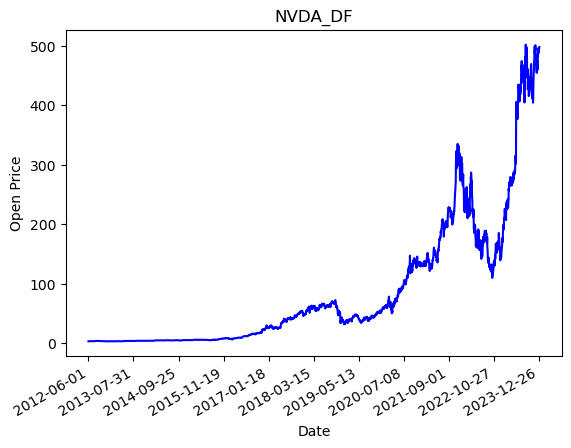

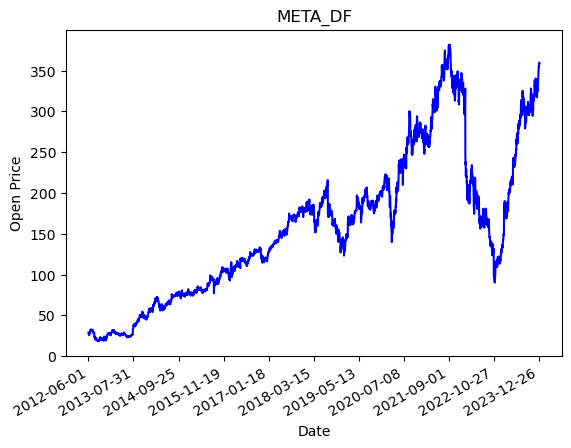

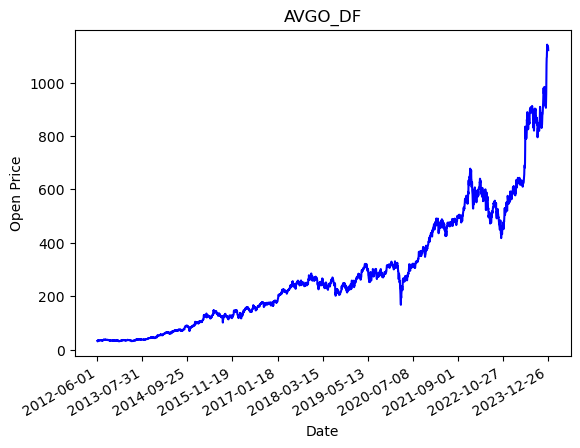

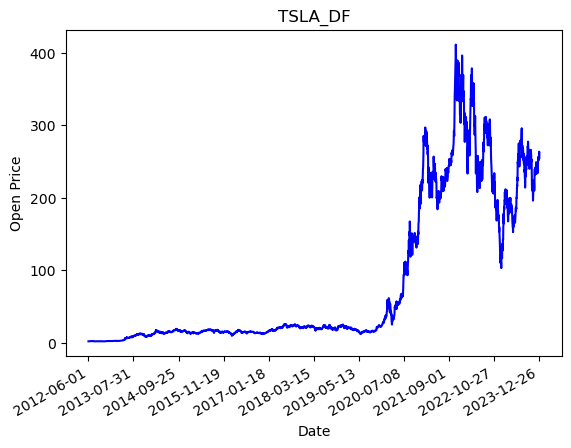

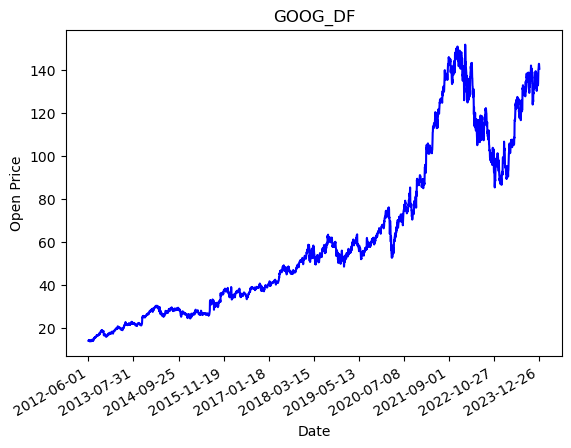

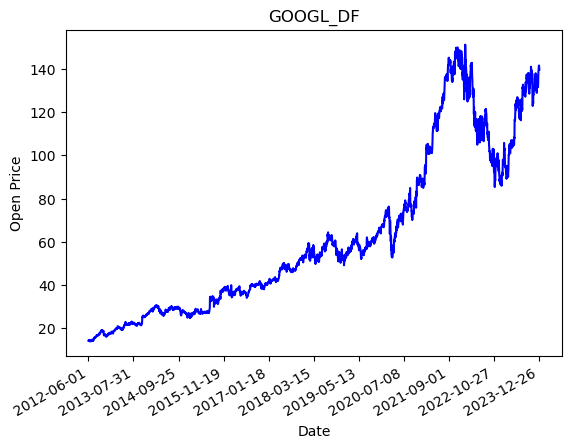

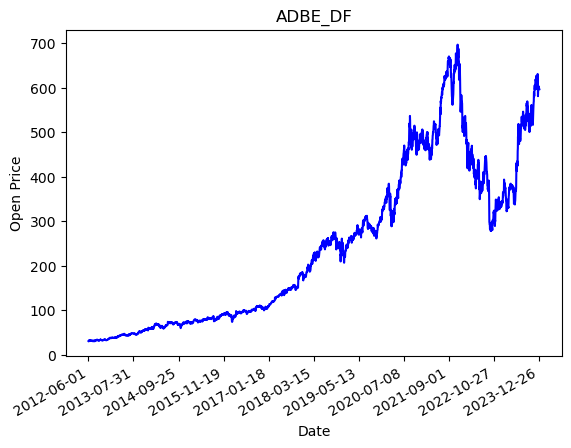

In [14]:
# Graficaremos cada variable
num_ticks = 10

for df in stocks_dict.keys():
    if df in macros:
        fig, ax = plt.subplots()
        
        ax.plot(stocks_dict[df]['Date'],stocks_dict[df].iloc[:,1], linestyle= '-', color='b')

        fig.autofmt_xdate()
        plt.xticks(stocks_dict[df]['Date'][::len(stocks_dict[df]['Date']) // num_ticks])
       
        plt.title(df)
        plt.xlabel(stocks_dict[df].columns[0])
        plt.ylabel(stocks_dict[df].columns[1])        

    if df in stocks:
        fig, ax = plt.subplots()
       
        ax.plot(stocks_dict[df]['Date'],stocks_dict[df].iloc[:,1], label= 'Open Price', linestyle= '-', color='b')
        #ax.plot(stocks_dict[df]['Date'],stocks_dict[df].iloc[:,2], label= 'Close Price', linestyle= '--', color='r')
        
        fig.autofmt_xdate()
        plt.xticks(stocks_dict[df]['Date'][::len(stocks_dict[df]['Date']) // num_ticks])
       
        plt.title(df)
        plt.xlabel(stocks_dict[df].columns[0])
        plt.ylabel(stocks_dict[df].columns[1] + ' Price')        
    
plt.show()    